<a href="https://colab.research.google.com/github/PrzemyslawSarnacki/AirQualityPrediction/blob/master/data_analisys.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a> 

## Wstępna obróbka i Analiza danych

Wczytanie potrzebnych bibliotek

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import numpy as np
import unicodedata
from io import BytesIO
import requests
import joblib


warnings.simplefilter('ignore')
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


def strip_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFKD', text.lower().replace("ł","l")) if unicodedata.category(c) != 'Mn')

CITIES = ["Warszawa", "Kraków", "Poznań", "Katowice", "Białystok"]
COORDINATES = {
    "warszawa": {
        "latitude": 52.2297,
        "longitude": 21.0122
    },
    "krakow": {
        "latitude": 50.0647,
        "longitude": 19.9450
    },
    "poznan": {
        "latitude": 52.4064,
        "longitude": 16.9252
    },
    "katowice": {
        "latitude": 50.2649,
        "longitude": 19.0238
    },
    "bialystok": {
        "latitude": 53.1325,
        "longitude": 23.1688
    },
}
PARAMETERS = ['pm25', 'pm10', 'no2', 'so2', 'o3', 'co']

indices = [""] + [f".{i}" for i in range(1, 6)]
data = {}

df = pd.read_csv("https://raw.githubusercontent.com/PrzemyslawSarnacki/AirQualityPrediction/master/data/airq_data_1.csv", index_col=0, parse_dates=True)

# load machine learning model for aqi prediction
m_link = 'https://github.com/PrzemyslawSarnacki/AirQualityPrediction/blob/master/data/aqi.joblib?raw=true'
m_file = BytesIO(requests.get(m_link).content)
aqi_model = joblib.load(m_file)

# fill columns with data
for city in CITIES:
    data[strip_accents(city)] = pd.DataFrame(df, columns=[f"{strip_accents(city)}{item}" for item in indices])
    data[strip_accents(city)] = data[strip_accents(city)].rename(columns=data[strip_accents(city)].iloc[0]).drop(data[strip_accents(city)].index[0])
    data[strip_accents(city)] = data[strip_accents(city)].drop(index="date.local").astype(float).interpolate(method="linear")
    data[strip_accents(city)].index = pd.to_datetime(data[strip_accents(city)].index)
    data[strip_accents(city)]["aqi"] = aqi_model.predict(data[strip_accents(city)].fillna(0))


In [42]:
maps = pd.concat(
    [data[strip_accents(city)].resample("M").mean().tail(12) for city in CITIES]
)
cities_by_month = pd.concat(
    [data[strip_accents(city)]["aqi"].resample("M").mean().tail(12) for city in CITIES],
    axis=1,
    keys=[f"aqi_{strip_accents(city)}" for city in CITIES],
)


In [44]:
import scipy.interpolate

x_arr = np.array([0, 100, 200, 300])
well_being = {
    "irriration": np.array([0, 2, 3, 4]),
    "depression": np.array([0, 2, 3, 4]),
    "stress": np.array([0.5, 2, 3, 4]),
    "worry": np.array([1, 2, 3, 4]),
    "happiness": np.array([4, 3, 2, 1]),
    "future_expectations": np.array([4, 3, 1.5, 1]),
    "swb": np.array([4, 0, -1, -3]),
}


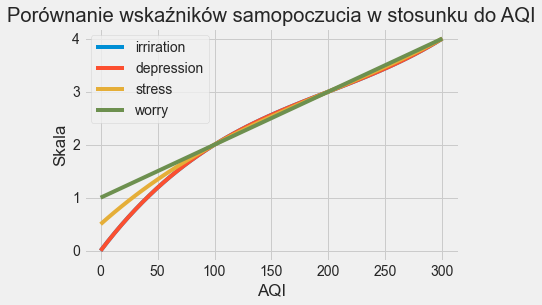

In [46]:
from itertools import islice

def get_n_items(d,f,n):
    """
    return sliced dictionary 
    f - means from (first element in the sliced array)
    n - means to (last element in the sliced array) if n exceeds size of array nothing 
    serious happens (last element is treated as n)
    """
    return dict(islice(d.items(),f, n))

plt.style.use("fivethirtyeight")

for being in get_n_items(well_being, 0, 4):
    interval = np.linspace(x_arr[0], x_arr[-1])
    interpolation = scipy.interpolate.interp1d(x_arr, well_being[being])
    spl = scipy.interpolate.UnivariateSpline(x_arr, well_being[being])
    plt.plot(interval, spl(interval))

plt.title("Porównanie wskaźników samopoczucia w stosunku do AQI")
plt.xlabel("AQI")
plt.ylabel("Skala")
plt.grid(True)
plt.legend([being for being in get_n_items(well_being, 0, 4)])

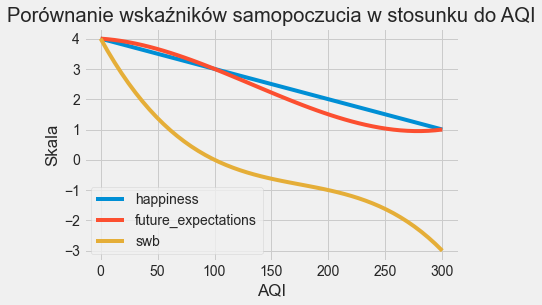

In [52]:
for being in get_n_items(well_being, 4, 7):
    interval = np.linspace(x_arr[0], x_arr[-1])
    interpolation = scipy.interpolate.interp1d(x_arr, well_being[being])
    spl = scipy.interpolate.UnivariateSpline(x_arr, well_being[being])
    plt.plot(interval, spl(interval))

plt.title("Porównanie wskaźników samopoczucia w stosunku do AQI")
plt.xlabel("AQI")
plt.ylabel("Skala")
plt.grid(True)
plt.legend([being for being in get_n_items(well_being, 4, 7)])

<AxesSubplot:>

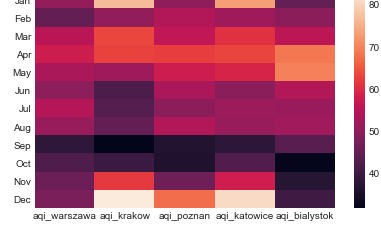

In [43]:
month_labels = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]
sns.heatmap(cities_by_month, yticklabels=month_labels)

Text(0.5, 0.99, 'DISTRIBUTIONS')

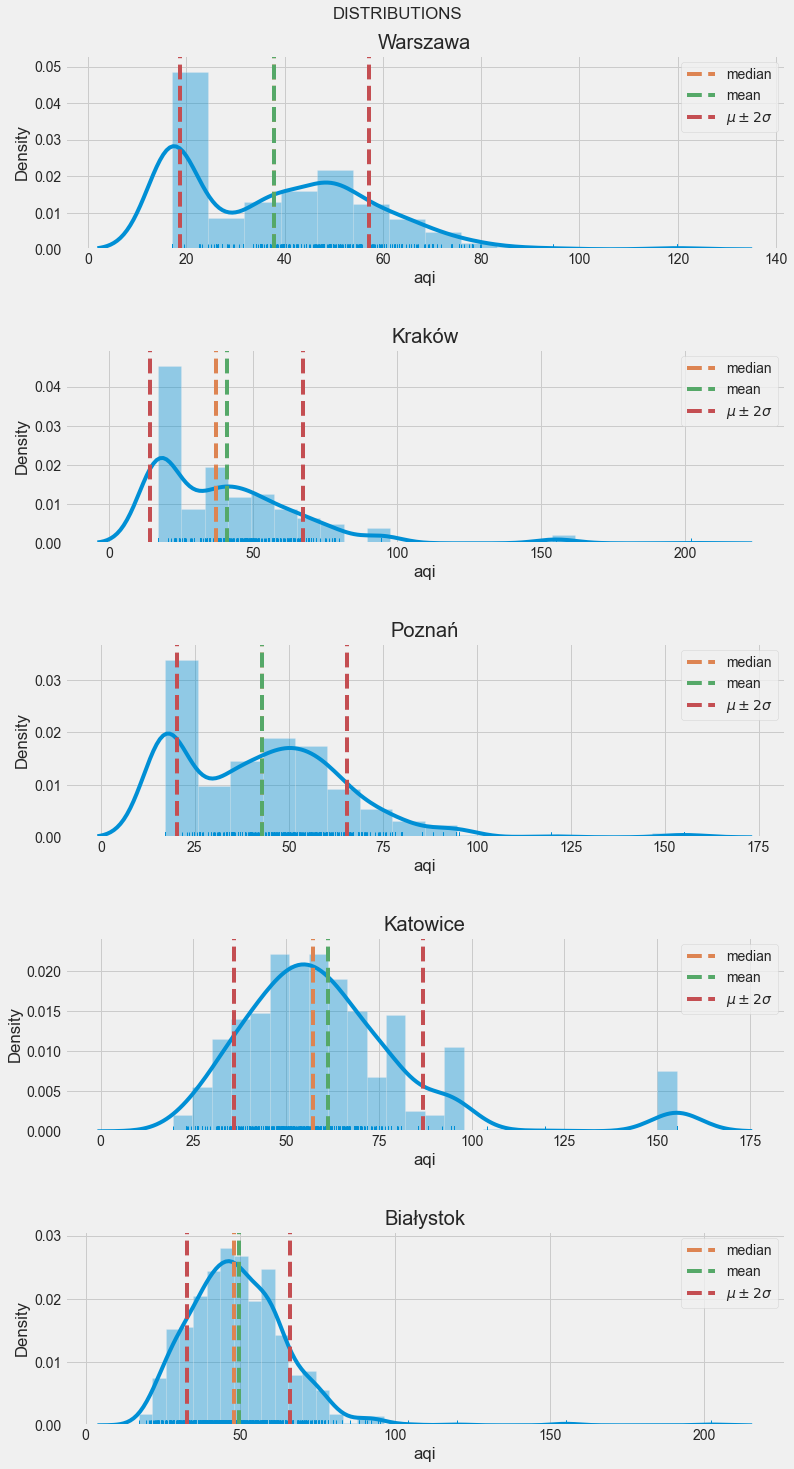

In [49]:
fig, ax = plt.subplots(len(data), 1, figsize=(12, 21))

for i, city in enumerate(CITIES):
    param_mean = np.mean(data[strip_accents(city)]["aqi"], axis=0)
    param_median = np.median(data[strip_accents(city)]["aqi"], axis=0)
    param_std = np.std(data[strip_accents(city)]["aqi"], axis=0)
    sns.distplot(a=data[strip_accents(city)]["aqi"], rug=True, ax=ax[i])
    ax[i].set(title=city)
    ax[i].axvline(x=param_median, color=sns_c[1], linestyle="--", label="median")

    ax[i].axvline(x=param_mean, color=sns_c[2], linestyle="--", label="mean")
    ax[i].axvline(
        x=param_mean + param_std,
        color=sns_c[3],
        linestyle="--",
        label=r"$\mu \pm 2\sigma$",
    )
    ax[i].axvline(x=param_mean - param_std, color=sns_c[3], linestyle="--")
    ax[i].legend()

plt.tight_layout(pad=3.0)
plt.suptitle("DISTRIBUTIONS", y=0.99)


In [50]:
pd.DataFrame(
    {"min_aqi": cities_by_month.min(axis=1), "City": cities_by_month.idxmin(axis=1)}
)


,min_aqi,City
2020-01-31,44.997571,aqi_bialystok
2020-02-29,44.966610,aqi_warszawa
2020-03-31,55.442118,aqi_warszawa
2020-04-30,57.693327,aqi_warszawa
2020-05-31,52.080285,aqi_krakow
2020-06-30,42.168627,aqi_krakow
2020-07-31,43.099686,aqi_krakow
2020-08-31,44.872319,aqi_krakow
2020-09-30,31.707089,aqi_krakow
2020-10-31,32.134366,aqi_bialystok


In [51]:
pd.DataFrame(
    {"max_aqi": cities_by_month.max(axis=1), "City": cities_by_month.idxmax(axis=1)}
)


,max_aqi,City
2020-01-31,76.899161,aqi_krakow
2020-02-29,54.382142,aqi_poznan
2020-03-31,63.411112,aqi_krakow
2020-04-30,68.629632,aqi_bialystok
2020-05-31,69.556627,aqi_bialystok
2020-06-30,54.333547,aqi_bialystok
2020-07-31,54.469986,aqi_warszawa
2020-08-31,54.330233,aqi_poznan
2020-09-30,43.749025,aqi_bialystok
2020-10-31,42.437504,aqi_katowice
